<a href="https://colab.research.google.com/github/ConstDahoud/simple_dnn/blob/main/04_spiral_classification_with_simple_dnn_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral classification with simple dnn using keras

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 6)

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Define spiral data generation function

In [2]:
def generate_spiral_dataset(num_class, num_data, num_dim=2):
    input_data = np.zeros((num_class*num_data, num_dim))    # data matrix(each row: single example)
    output_data = np.zeros((num_class*num_data), dtype=np.uint8)    # labels

    for class_index in range(num_class):
        indices = range(num_data*class_index, num_data*(class_index+1))
        radiuses = np.linspace(0.0, 1, num_data)    # a range of the radiuses: [0, 1]
        thetas = np.linspace(4*class_index, 4*(class_index+1), num_data)    # theta = 4
        noise = np.random.randn(num_data) * 0.2
        thetas += noise
        input_data[indices] = np.column_stack((radiuses*np.sin(thetas), radiuses*np.cos(thetas)))
        output_data[indices] = class_index    # shape: (num_class*num_data, )
    return input_data, output_data

## Generate train data and test data

In [3]:
X_train, y_train = generate_spiral_dataset(num_class=3, num_data=200, num_dim=2)
X_test, y_test = generate_spiral_dataset(num_class=3, num_data=200, num_dim=2)

## Let visualize the data

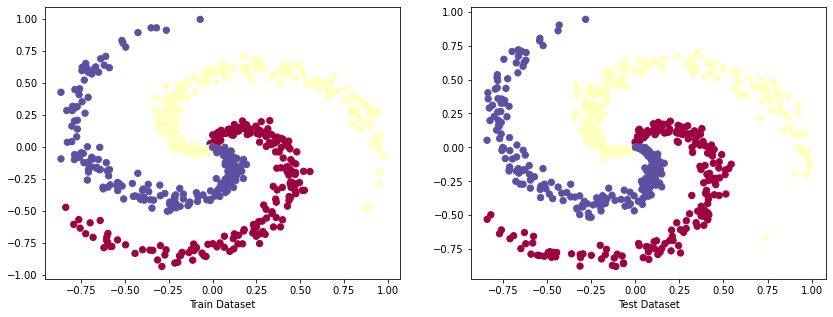

In [4]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Train Dataset")
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.show()

## Define a function for shuffling the data

In [5]:
@tf.function
def column_divide(item):
    sin, cos, label = item[0], item[1], item[2]
    return [sin, cos], label

def shuffle_dataset(inputs, outputs, buffer_size=1000, batch_size=32):
    input_tensors = tf.constant(inputs, dtype=tf.float32)
    output_tensors = tf.constant(outputs, dtype=tf.float32)[:, tf.newaxis]
    dataset = keras.backend.concatenate((input_tensors, output_tensors), axis=1)    # (600, 3)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)    # 600 items, the shape of each item: (3, )
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.map(column_divide, num_parallel_calls=True)    # the shape of each item: ([sin, cos], (label))
    dataset = dataset.batch(batch_size=batch_size)
    # per one item: ([[sin_1, cos_1],[sin_2, cos_2], ... [sin_batch_size, cos_batch_size]], [label_1, label_2, ..., label_batch_size])
    return dataset.prefetch(1)

## Shuffle the data

In [6]:
train_set = shuffle_dataset(X_train, y_train, buffer_size=600, batch_size=600)
valid_set = shuffle_dataset(X_train, y_train, buffer_size=600, batch_size=600)

## Define the model

In [7]:
simple_dnn = keras.models.Sequential([
    keras.layers.Dense(60, kernel_initializer="he_normal", activation='elu', input_shape=[2]),
    keras.layers.Dense(60, kernel_initializer="he_normal", activation='elu'),
    keras.layers.Dense(60, kernel_initializer="he_normal", activation='elu'),
    keras.layers.Dense(60, kernel_initializer="he_normal", activation='elu'),
    keras.layers.Dense(3, activation='softmax')
])

## Compile the model

In [8]:
simple_dnn.compile(optimizer='Nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [9]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_simple_dnn.h5", save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = simple_dnn.fit(train_set, epochs=1000,
                         validation_data=valid_set,
                         callbacks=[checkpoint_cb, earlystopping_cb])
simple_dnn = keras.models.load_model("my_simple_dnn.h5")

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 1.2233 - accuracy: 0.4350 - val_loss: 1.0031 - val_accuracy: 0.5067
Epoch 2/1000
1/1 [==============================] - 0s 157ms/step - loss: 1.0031 - accuracy: 0.5067 - val_loss: 0.9015 - val_accuracy: 0.5567
Epoch 3/1000
1/1 [==============================] - 0s 176ms/step - loss: 0.9015 - accuracy: 0.5567 - val_loss: 0.8398 - val_accuracy: 0.5400
Epoch 4/1000
1/1 [==============================] - 0s 172ms/step - loss: 0.8398 - accuracy: 0.5400 - val_loss: 0.7994 - val_accuracy: 0.5667
Epoch 5/1000
1/1 [==============================] - 0s 172ms/step - loss: 0.7994 - accuracy: 0.5667 - val_loss: 0.7712 - val_accuracy: 0.5717
Epoch 6/1000
1/1 [==============================] - 0s 163ms/step - loss: 0.7712 - accuracy: 0.5717 - val_loss: 0.7497 - val_accuracy: 0.5800
Epoch 7/1000
1/1 [==============================] - 0s 167ms/step - loss: 0.7497 - accuracy: 0.5800 - val_loss: 0.7318 - val_accuracy: 0.5833
Epoch 8/1

## Test the model

In [10]:
test_output_pred = simple_dnn.predict(X_test)

## Let visualize the result

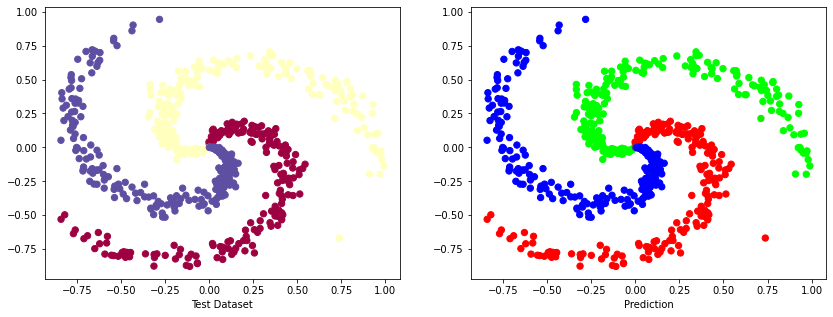

In [11]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.subplot(1,2,2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_output_pred, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Prediction")
plt.show()